In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import pickle

from tqdm import tqdm

from collections import Counter

from linearization.analyzer import SAELinearizer
from linearization.visualization import visualize_topk

In [3]:
# Hyperparameters
# SAE_NUM = "0_8192"
# SAE_NUM = "1_32768"
# SAE_NUM = "2_32768"


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

N_TOP_TOKENS = 30

NORMALIZE_SAE_VECS = False
# NORMALIZE_SAE_VECS = True

In [4]:
path = "../data/pickled_linearizers/gpt2_small_resid_mid.pkl"

# # Get SAE names automatically
# prefix = "../scripts/checkpoints/64x_resid_mid/"
# sae_names = []
# for i in range(12):
#     with os.scandir(prefix + f"layer{i}") as it:
#         for entry in it:
#             if entry.name.startswith("final") and not entry.name.endswith("sparsity.pt") and entry.is_file():
#                 sae_names.append(entry.path)
# print("SAE names:", sae_names)

sae_names = [
    f"../scripts/checkpoints/64x_resid_mid/layer{i}/final_sparse_autoencoder_gpt2-small_blocks.{i}.hook_resid_mid_49152.pt"
    for i in range(12)
]

if os.path.exists(path):
    lin = pickle.load(open(path, "rb"))
else:
    lin = SAELinearizer(
        model_name="gpt2-small",
        sae_names=sae_names,
        layers=list(range(12)),
        dataset_name="NeelNanda/pile-10k",
        act_name="resid_mid",
        num_batches=100,
        use_gpt=True,
        # dict_mult=64,
        # hook_point="resid_mid",
        # run_analysis=False,
    )
with open(path, "wb") as f:
    pickle.dump(lin, f)

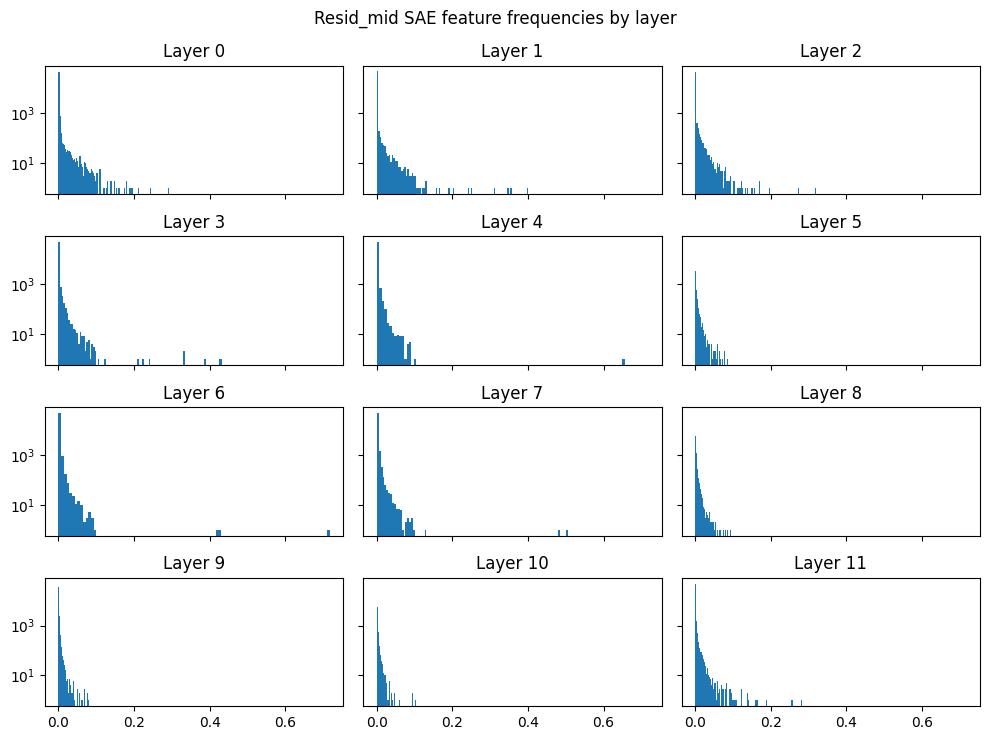

In [14]:
# Feature distributions
fig, ax = plt.subplots(4, 3, figsize=(10, 7.5), sharey=True, sharex=True)
ax = ax.flatten()
for i, sae_name in enumerate(sae_names):
    ax[i].hist(lin.frequencies[sae_name].cpu().numpy(), bins=100)
    ax[i].set_title(f"Layer {i}")
    ax[i].set_yscale("log")

plt.suptitle("Resid_mid SAE feature frequencies by layer")
plt.tight_layout()
plt.show()

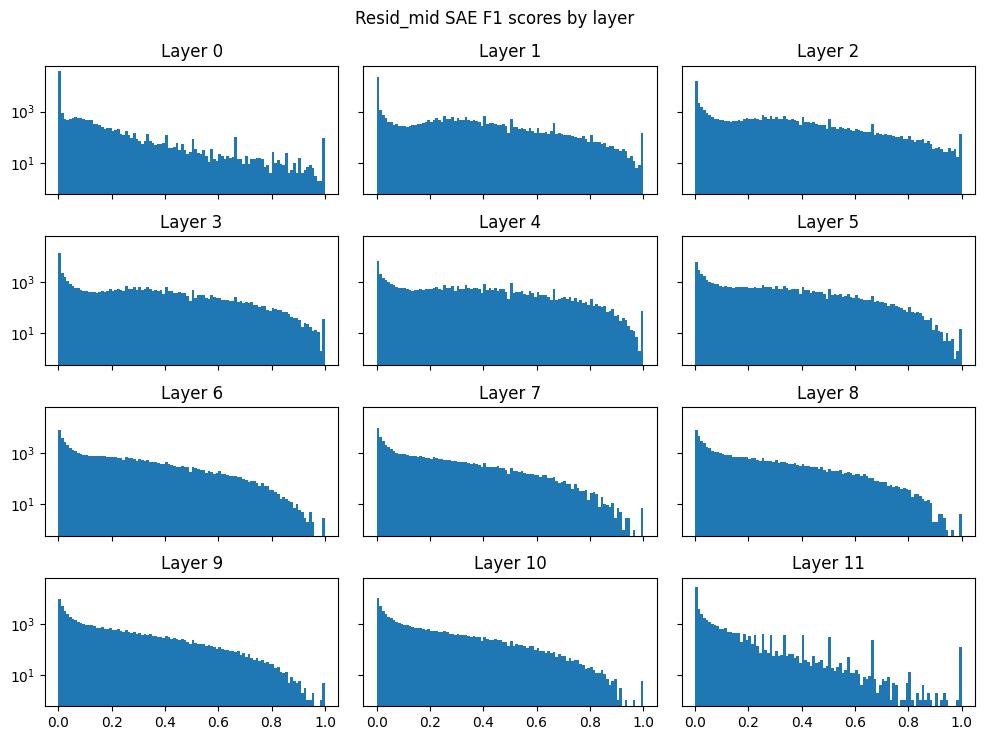

In [16]:
# Feature distributions
fig, ax = plt.subplots(4, 3, figsize=(10, 7.5), sharey=True, sharex=True)
ax = ax.flatten()
for i, sae_name in enumerate(sae_names):
    ax[i].hist(lin.f1_scores[sae_name]["f1_scores"], bins=100)
    ax[i].set_title(f"Layer {i}")
    ax[i].set_yscale("log")

plt.suptitle("Resid_mid SAE F1 scores by layer")
plt.tight_layout()
plt.show()

/tmp/ipykernel_5514/2068912706.py:41: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()  # Adjust layout to not cut off labels
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy 

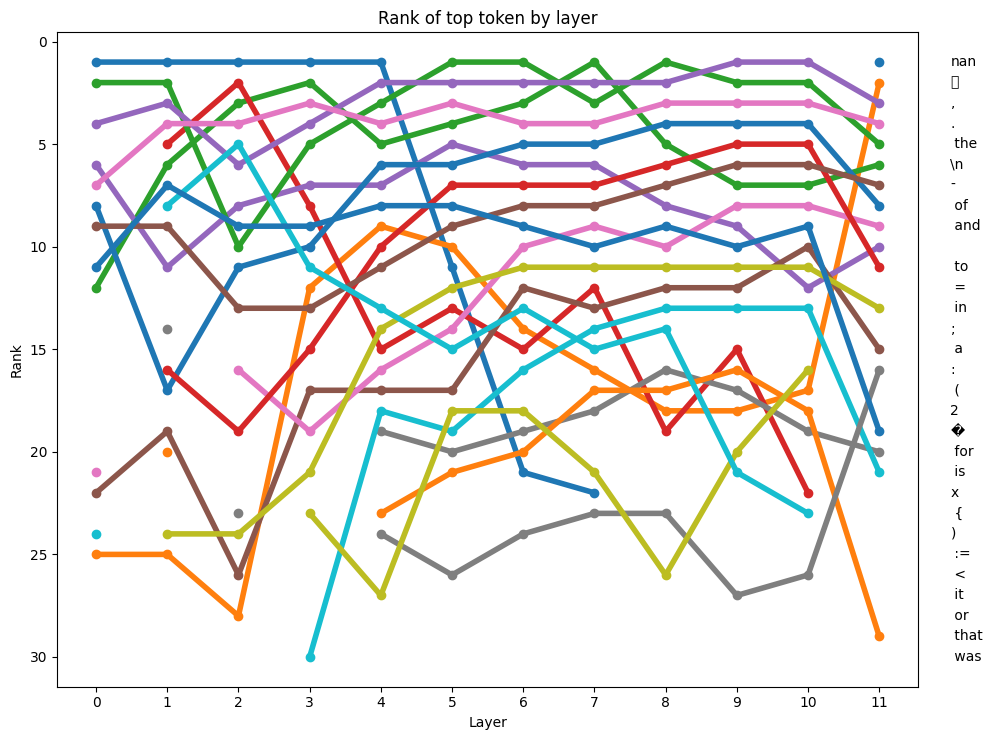

In [25]:
# Top token distributions

top_tokens_by_layer = pd.DataFrame()
for i, sae_name in enumerate(sae_names):
    top_tokens = Counter(lin.f1_scores[sae_name]["top_tokens"]).most_common(N_TOP_TOKENS)
    top_tokens_by_layer[f"{i} token"] = [x[0] for x in top_tokens]
    top_tokens_by_layer[f"{i} count"] = [x[1] for x in top_tokens]

# Make a line graph showing the relative positions of tokens (ChatGPT)
# Transform the DataFrame to have 'token', 'layer', and 'rank'
data = []
for layer in range(len(sae_names)):
    tokens = top_tokens_by_layer[f"{layer} token"]
    counts = top_tokens_by_layer[f"{layer} count"]
    for rank, (token, count) in enumerate(zip(tokens, counts), start=1):
        data.append({"token": token, "layer": layer, "rank": rank})

# Create a new DataFrame
ranked_tokens_df = pd.DataFrame(data)

pivot_df = ranked_tokens_df.pivot(index="layer", columns="token", values="rank")

plt.figure(figsize=(10, N_TOP_TOKENS / 4))

# Plot each token with a label at the end
for token in pivot_df.columns:
    if pivot_df[token].isna().sum() < 5:
        plt.plot(pivot_df.index, pivot_df[token], marker="o", lw=4)
    # Add text label at the end of each line
    end_x = pivot_df.index[-1] + 1  # Slightly right of the last data point
    end_y = pivot_df[token].iloc[-1]  # Y-value at the last data point
    if token == "\n":
        token = "\\n"
    plt.text(end_x, end_y, token, verticalalignment="center")

plt.gca().invert_yaxis()  # Rank 1 at the top
plt.title("Rank of top token by layer")
plt.xlabel("Layer")
plt.ylabel("Rank")
plt.xticks(range(len(sae_names)))  # Assuming there are 6 layers as per the initial example
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()

  0%|          | 0/144 [00:00<?, ?it/s]

/tmp/ipykernel_12257/3967295714.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[layer1, layer2].set_ylim(0, torch_hist.max().cpu() * 4)
  1%|          | 1/144 [00:00<00:48,  2.96it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 9.00 GiB. GPU 0 has a total capacty of 23.65 GiB of which 36.25 MiB is free. Process 96919 has 7.50 GiB memory in use. Process 201777 has 16.11 GiB memory in use. Of the allocated memory 15.65 GiB is allocated by PyTorch, and 2.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

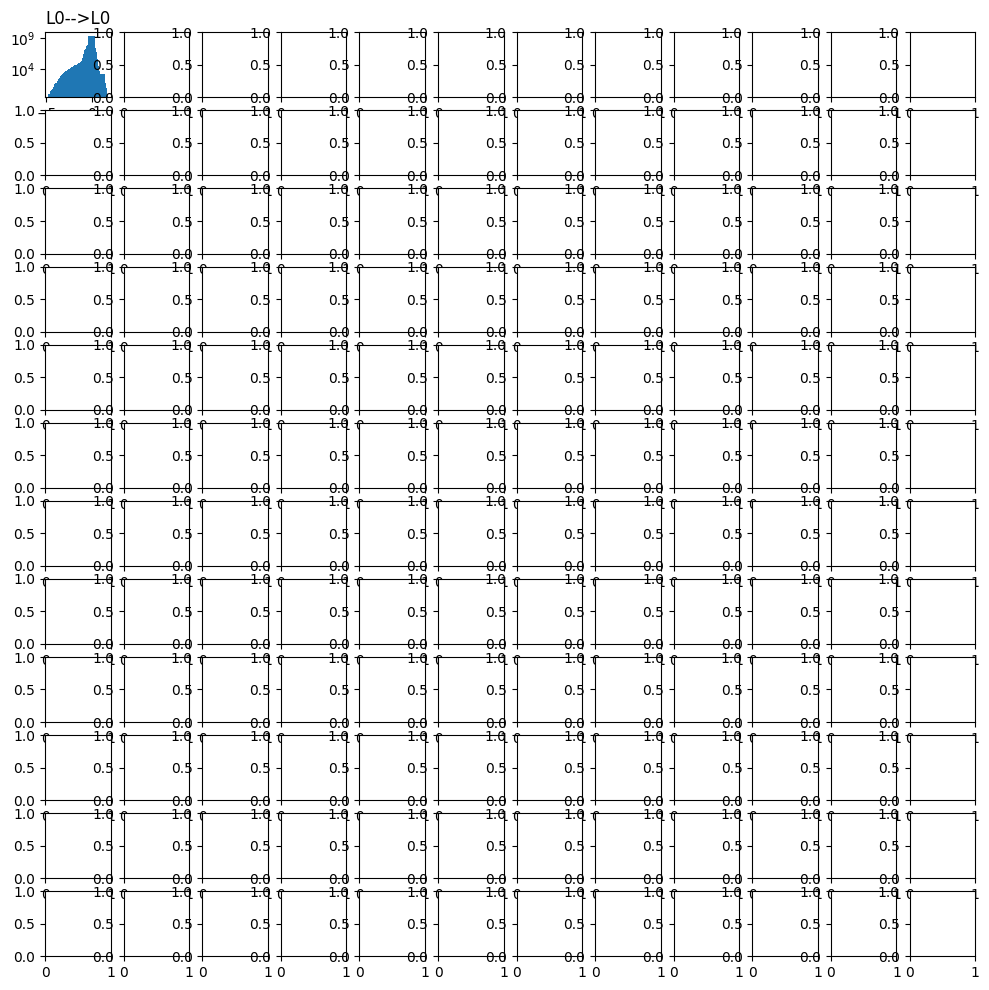

In [5]:
# Pairwise encoder-decoder dot products [weights based]:

fig, axs = plt.subplots(len(sae_names), len(sae_names), figsize=(len(sae_names), len(sae_names)))
my_tqdm = tqdm(total=len(sae_names) ** 2)

with torch.no_grad():
    for layer1, name1 in enumerate(sae_names):
        for layer2, name2 in enumerate(sae_names):
            enc = lin.saes[name1].W_enc.to(DEVICE)
            dec = lin.saes[name2].W_dec.to(DEVICE)

            if NORMALIZE_SAE_VECS:
                enc = torch.nn.functional.normalize(enc, p=2, dim=1)
                dec = torch.nn.functional.normalize(dec, p=2, dim=0)

            # Compute pairwise dot-products and drop infinite values
            dot = (dec @ enc).flatten().to(torch.float32)
            torch_hist = torch.histc(dot)

            if NORMALIZE_SAE_VECS:
                xmin, xmax = -1, 1
            else:
                xmin, xmax = dot.min().cpu(), dot.max().cpu()

            axs[layer1, layer2].bar(np.linspace(xmin, xmax, len(torch_hist)), torch_hist.cpu())
            axs[layer1, layer2].set_yscale("log")
            axs[layer1, layer2].set_title(f"L{layer1}-->L{layer2}")
            axs[layer1, layer2].set_ylim(0, torch_hist.max().cpu() * 4)
            my_tqdm.update(1)

plt.tight_layout()